In [1]:
rm(list = ls())
library(LalRUtils)
libreq(data.table, tidyverse, anytime, patchwork, plotly, lubridate, zoo)
theme_set(lal_plot_theme())
options(repr.plot.width = 15, repr.plot.height=12)

     wants        loaded
[1,] "data.table" TRUE  
[2,] "tidyverse"  TRUE  
[3,] "anytime"    TRUE  
[4,] "patchwork"  TRUE  
[5,] "plotly"     TRUE  
[6,] "lubridate"  TRUE  
[7,] "zoo"        TRUE  


# NYT county level time series 
https://github.com/nytimes/covid-19-data

In [2]:
#%% check timestamp at https://github.com/nytimes/covid-19-data
df = fread("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")
df[, d := anydate(date)]
df %>% glimpse

Rows: 1,946,595
Columns: 7
$ date   <date> 2020-01-21, 2020-01-22, 2020-01-23, 2020-01-24, 2020-01-24, 20…
$ county <chr> "Snohomish", "Snohomish", "Snohomish", "Cook", "Snohomish", "Or…
$ state  <chr> "Washington", "Washington", "Washington", "Illinois", "Washingt…
$ fips   <int> 53061, 53061, 53061, 17031, 53061, 6059, 17031, 53061, 4013, 60…
$ cases  <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ deaths <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ d      <date> 2020-01-21, 2020-01-22, 2020-01-23, 2020-01-24, 2020-01-24, 20…


In [3]:
setorder(df, state, county, date)
df[,  `:=`(
  cfr = deaths/cases,
  new_cases  = cases - shift(cases),
  new_deaths = deaths - shift(deaths)
), by = .(state, county)]
# clean up
df[ ,`:=`(new_deaths = ifelse(new_deaths < 0, 0, new_deaths),
          new_cases  = ifelse(new_cases < 0, 0, new_cases)
              )]
df = df[d >= "2020-03-01"]
rawvars = c("cases", "deaths", "new_cases", "new_deaths")

In [4]:
df[order(-date, -cases)][1:20]
fwrite(df, 'data/nyt_county_level.csv.gz')

date,county,state,fips,cases,deaths,d,cfr,new_cases,new_deaths
<date>,<chr>,<chr>,<int>,<int>,<int>,<date>,<dbl>,<dbl>,<dbl>
2021-11-23,Los Angeles,California,6037,1521901,27046,2021-11-23,0.017771,693,29
2021-11-23,New York City,New York,NA,1148868,34757,2021-11-23,0.030253,1489,10
2021-11-23,Maricopa,Arizona,4013,787377,12662,2021-11-23,0.016081,1600,59
2021-11-23,Miami-Dade,Florida,12086,677570,9121,2021-11-23,0.013461,0,0
2021-11-23,Cook,Illinois,17031,668246,12003,2021-11-23,0.017962,1446,6
2021-11-23,Harris,Texas,48201,584217,9491,2021-11-23,0.016246,245,14
2021-11-23,Dallas,Texas,48113,411446,5582,2021-11-23,0.013567,0,21
2021-11-23,San Diego,California,6073,404269,4317,2021-11-23,0.010679,1385,0
2021-11-23,Riverside,California,6065,384645,5395,2021-11-23,0.014026,208,23


### Rolling Mean Function

In [5]:
rollmeaneR = function(df,  smoothvars = rawvars, grouping = c("state", "county"), sm_k = 5){
    f = copy(df)
    setorderv(f, cols = c(grouping, 'd'))
    f[, paste0("rm", "_", smoothvars) := lapply(.SD, rollmean, k = sm_k, fill = NA, na.pad = T), 
       by = grouping, .SDcols = smoothvars]
    return(f)
}

# Nationwide 

In [6]:
options(warnings = -1)

In [7]:
npan = df[, lapply(.SD, sum, na.rm = T), by = .(d), .SDcols = rawvars]
npan[, gr := 1]
npan[, cfr := deaths/cases]
npan = rollmeaneR(npan, c(rawvars, 'cfr'), grouping = "gr")
npan[, day := weekdays(d)]
npan[, weekend := ifelse(day %in% c("Saturday", "Sunday"), 1, 0)]
npan[order(-d)][1:5]

d,cases,deaths,new_cases,new_deaths,gr,cfr,rm_cases,rm_deaths,rm_new_cases,rm_new_deaths,rm_cfr,day,weekend
<date>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2021-11-23,47944266,774580,93356,1496,1,0.01616,NA,NA,NA,NA,NA,Tuesday,0
2021-11-22,47851512,773106,158934,1234,1,0.01616,NA,NA,NA,NA,NA,Monday,0
2021-11-21,47692614,771961,31620,126,1,0.01619,47753962,772600,91230,1119,0.01618,Sunday,1
2021-11-20,47661242,771835,43634,725,1,0.01619,47665215,771591,94893,1491,0.01619,Saturday,1
2021-11-19,47620178,771520,128608,2014,1,0.01620,47572964,770211,88796,1573,0.01619,Friday,0


`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”


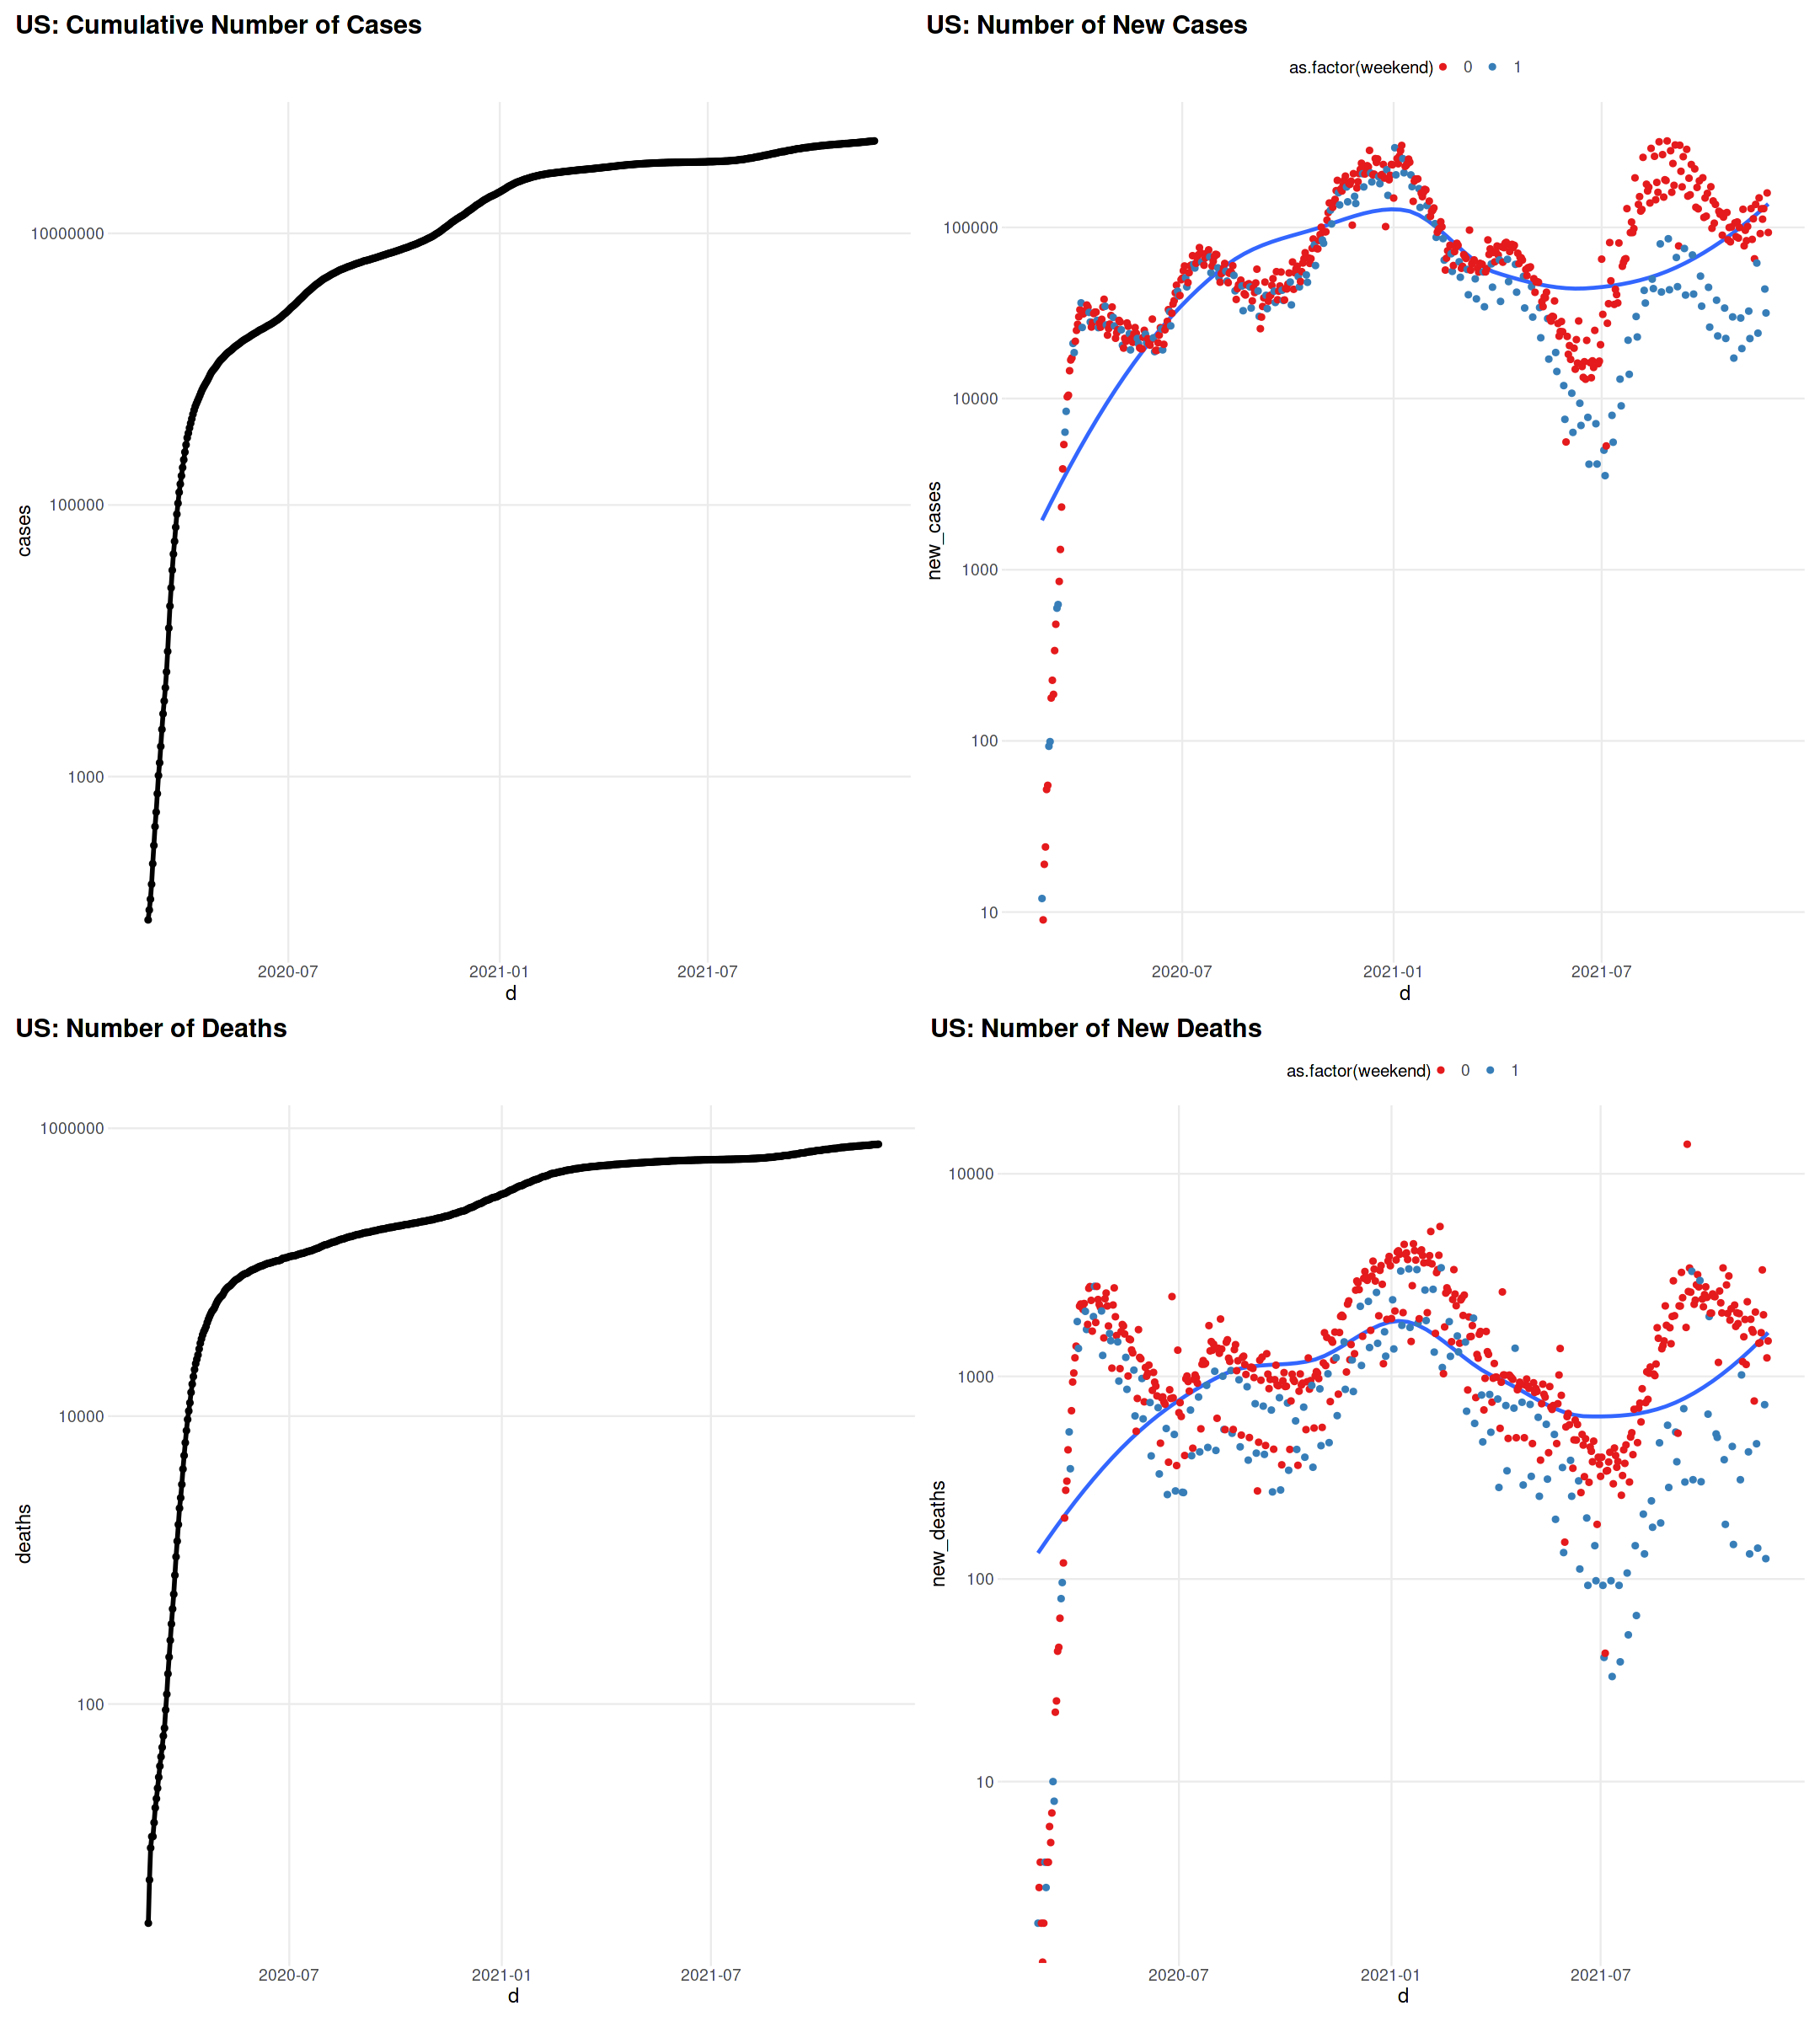

In [8]:
options(repr.plot.width = 20, repr.plot.height=16)
p1 = ggplot(npan, aes(x = d, y = cases)) +
  geom_line(size = 1.2) + geom_point()+ 
  scale_y_log10() +
  ggtitle("US: Cumulative Number of Cases")

p11 = ggplot(npan, aes(x = d, y = new_cases)) +
#   geom_line(aes(y = rm_new_cases)) +
    geom_smooth(se = F) +
    geom_point(aes( colour = as.factor(weekend))) +
    scale_y_log10() +
    scale_colour_brewer(palette = "Set1") + 
    ggtitle("US: Number of New Cases")

p2 = ggplot(npan, aes(x = d, y = deaths)) +
  geom_line(size = 1.2) + geom_point() +
  scale_y_log10() +
  ggtitle("US: Number of Deaths")

p22 = ggplot(npan, aes(x = d, y = new_deaths)) +
#   geom_line(aes(y = rm_new_deaths)) +
    geom_smooth(se = F) +
    geom_point(aes(colour = as.factor(weekend))) +
    scale_y_log10() + 
    scale_colour_brewer(palette = "Set1") + 
    ggtitle("US: Number of New Deaths")

options(repr.plot.width = 18, repr.plot.height=20)
(p1 | p11) /( p2 | p22)

In [9]:
options(repr.plot.width = 10, repr.plot.height=8)
nat_cfr = ggplot(npan[d>= "2020-03-15"], aes(x = d, y = cfr)) +
  geom_line(aes(y = rm_cfr)) + geom_point()+ 
  ggtitle("US: CFR")

## State Panel 

In [10]:
stpan = df[, lapply(.SD, sum, na.rm = T), by = .(state, d), .SDcols = rawvars]
(t10 = stpan[d == max(d)][order(-cases)][1:10])
stpan[, cfr := deaths/cases]
stpan = rollmeaneR(stpan, c(rawvars, 'cfr'), grouping = "state")

state,d,cases,deaths,new_cases,new_deaths
<chr>,<date>,<int>,<int>,<dbl>,<dbl>
California,2021-11-23,5055959,74157,4541,116
Texas,2021-11-23,4306962,73832,3991,96
Florida,2021-11-23,3682809,61147,1605,0
New York,2021-11-23,2684084,56775,5619,34
Illinois,2021-11-23,1785089,29234,4632,19
Pennsylvania,2021-11-23,1696959,33003,5186,72
Ohio,2021-11-23,1653380,26190,6143,127
Georgia,2021-11-23,1623871,29181,1351,61
North Carolina,2021-11-23,1523894,18662,1377,12


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 40 row(s) containing missing values (geom_path).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 40 row(s) containing missing values (geom_path).”


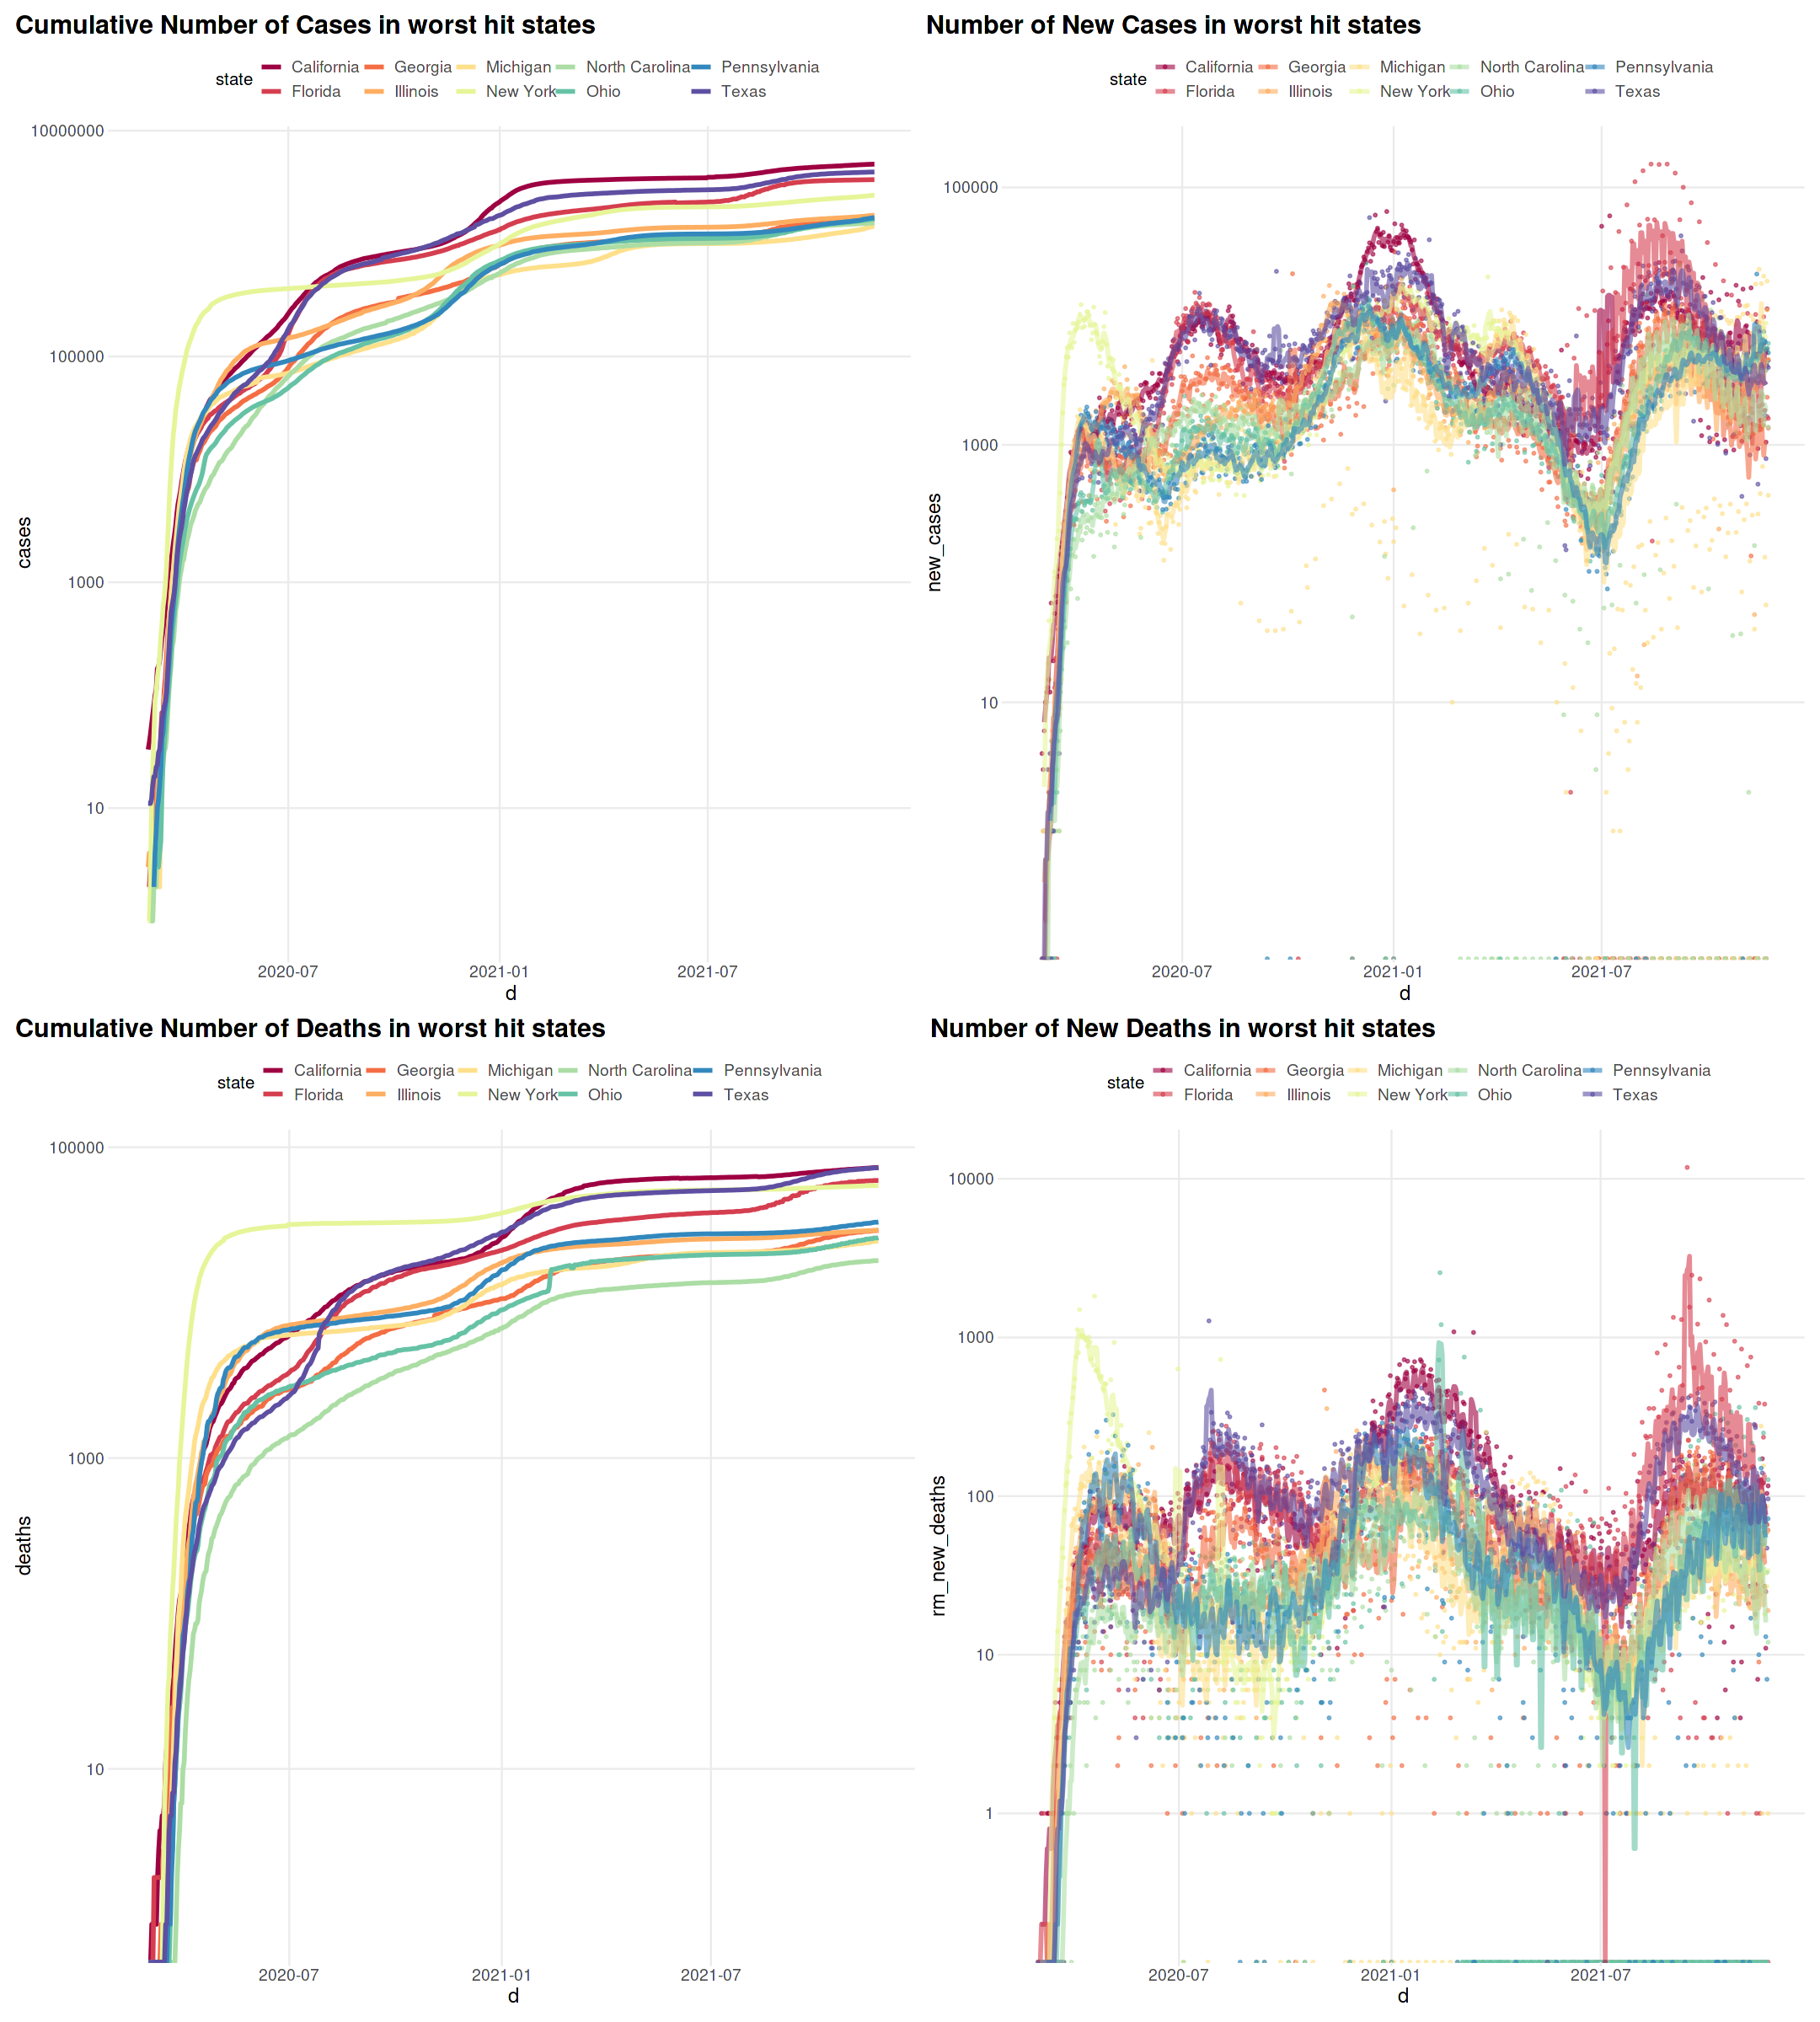

In [11]:
options(repr.plot.width = 20, repr.plot.height=16)
p1 = ggplot(stpan[state %in% t10$state], aes(x = d, y = cases, group = state, colour = state)) +
  geom_line(size = 1.2) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Cumulative Number of Cases in worst hit states")

p11 = ggplot(stpan[state %in% t10$state], aes(x = d, group = state, colour = state)) +
  geom_point(aes(y = new_cases), size = 0.6, alpha = 0.6) +
  geom_line(aes(y = rm_new_cases), size = 1.2, alpha = 0.6) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Number of New Cases in worst hit states")

p2 = ggplot(stpan[state %in% t10$state], aes(x = d, y = deaths, group = state, colour = state)) +
  geom_line(size = 1.2) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Cumulative Number of Deaths in worst hit states")

p22 = ggplot(stpan[state %in% t10$state], aes(x = d, y = rm_new_deaths, group = state, colour = state)) +
  geom_point(aes(y = new_deaths), size = 0.6, alpha = 0.6) +
  geom_line(aes(y = rm_new_deaths), size = 1.2, alpha = 0.6) +
  scale_y_log10() + 
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Number of New Deaths in worst hit states")

options(repr.plot.width = 18, repr.plot.height=20)
(p1 | p11) /( p2 | p22)

In [ ]:
ggplotly(p11)

## CA: Subregions

In [15]:
bay_counties = c(
  "San Francisco", "San Mateo", "Santa Clara",
  "Alameda", "Contra Costa", "Marin"
)

socal = c("Los Angeles", "Orange", "Ventura", "San Bernadino", "Riverside",
          "Imperial", "Kern", "San Diego", "Santa Barbara", "San Luis Obispo")

ca_all = df[state == "California"]
ca_all[, metro := case_when(
    county %in% bay_counties ~ "Bay",
    county %in% socal        ~ "SoCal",
    TRUE                     ~ "Elsewhere")]
vars = c("cases", "deaths", "new_cases", "new_deaths")
ca_div = ca_all[, lapply(.SD, sum, na.rm = T), 
   by = .(metro, d), .SDcols = vars]

In [16]:
ca_div = rollmeaneR(ca_div, smoothvars = vars, grouping = 'metro')

In [17]:
kvs = c("cases", "deaths", "new_cases", "new_deaths", 'd')
cur = ca_div[order(-d), .SD[1], by = metro, .SDcols = kvs]
cur[, lapply(.SD, sum, na.rm = T), .SDcols = vars]

cases,deaths,new_cases,new_deaths
<int>,<int>,<dbl>,<dbl>
5055959,74157,4541,116


Warning message:
“Removed 12 row(s) containing missing values (geom_path).”
Warning message:
“Removed 12 row(s) containing missing values (geom_path).”


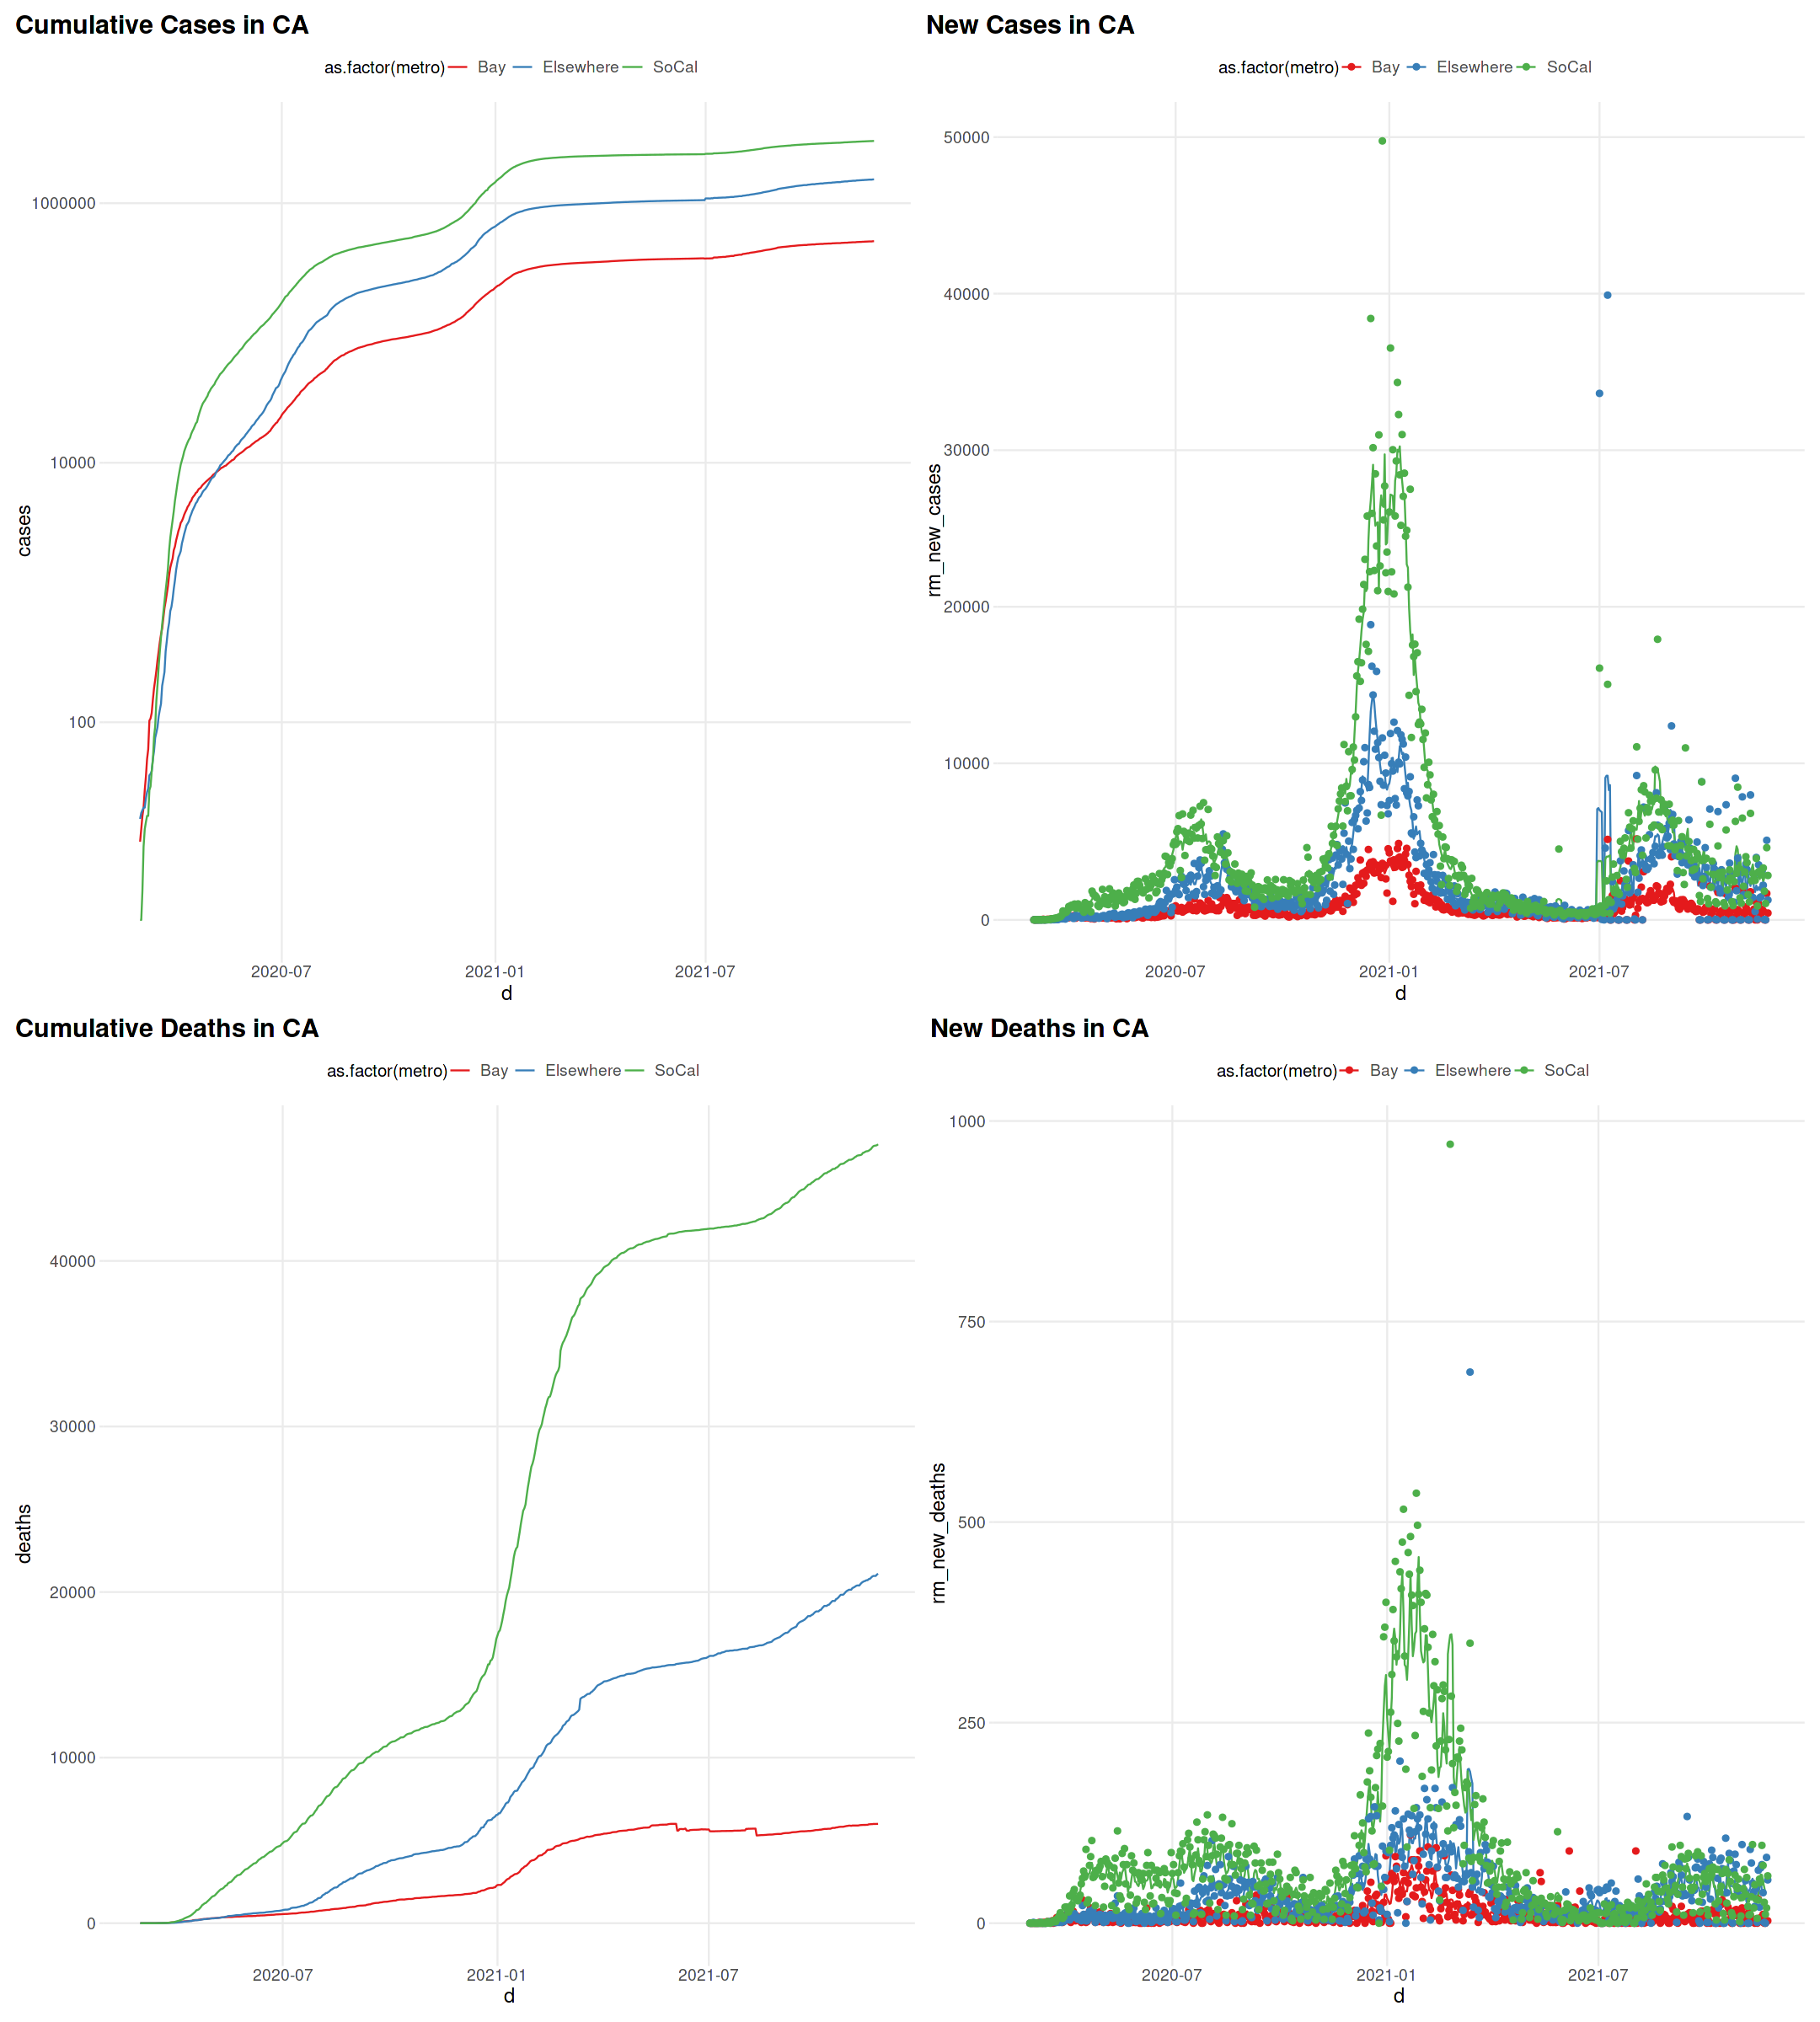

In [18]:
p1 = ggplot(ca_div, aes(x = d, y = cases, group = as.factor(metro), colour = as.factor(metro))) +
    geom_line() + scale_y_log10()+
  scale_colour_brewer(palette = 'Set1') +
    ggtitle("Cumulative Cases in CA")
p2 = ggplot(ca_div, aes(x = d,  group = as.factor(metro), colour = as.factor(metro))) +
  geom_line(aes(y = rm_new_cases)) +
  geom_point(aes(y = new_cases)) +
  scale_colour_brewer(palette = 'Set1') +
    ggtitle("New Cases in CA")
p3 = ggplot(ca_div, aes(x = d, y = deaths, group = as.factor(metro), colour = as.factor(metro))) +
  geom_line() +
  scale_colour_brewer(palette = 'Set1') +
    ggtitle("Cumulative Deaths in CA")

p4 = ggplot(ca_div, aes(x = d, y = rm_new_deaths, group = as.factor(metro), colour = as.factor(metro))) +
  geom_line(aes(y = rm_new_deaths)) +
  geom_point(aes(y = new_deaths)) +
  scale_colour_brewer(palette = 'Set1') +
    ggtitle("New Deaths in CA")

options(repr.plot.width = 18, repr.plot.height=20)
(p1 | p2 ) / (p3 | p4)

## Counties within the Bay Area

In [19]:
bayrea_mar = rollmeaneR(df[county %in% bay_counties & state == "California" & d>= "2020-03-01"])
bayrea_mar[, cfr := deaths/cases]
bayrea_mar[d == max(d)]

date,county,state,fips,cases,deaths,d,cfr,new_cases,new_deaths,rm_cases,rm_deaths,rm_new_cases,rm_new_deaths
<date>,<chr>,<chr>,<int>,<int>,<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-11-23,Alameda,California,6001,124627,1491,2021-11-23,0.01196,123,2,NA,NA,NA,NA
2021-11-23,Contra Costa,California,6013,103208,1045,2021-11-23,0.01013,70,0,NA,NA,NA,NA
2021-11-23,Marin,California,6041,18327,248,2021-11-23,0.01353,13,0,NA,NA,NA,NA
2021-11-23,San Francisco,California,6075,56565,669,2021-11-23,0.01183,37,0,NA,NA,NA,NA
2021-11-23,San Mateo,California,6081,56028,627,2021-11-23,0.01119,40,0,NA,NA,NA,NA
2021-11-23,Santa Clara,California,6085,151010,1920,2021-11-23,0.01271,154,1,NA,NA,NA,NA


### Cases

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


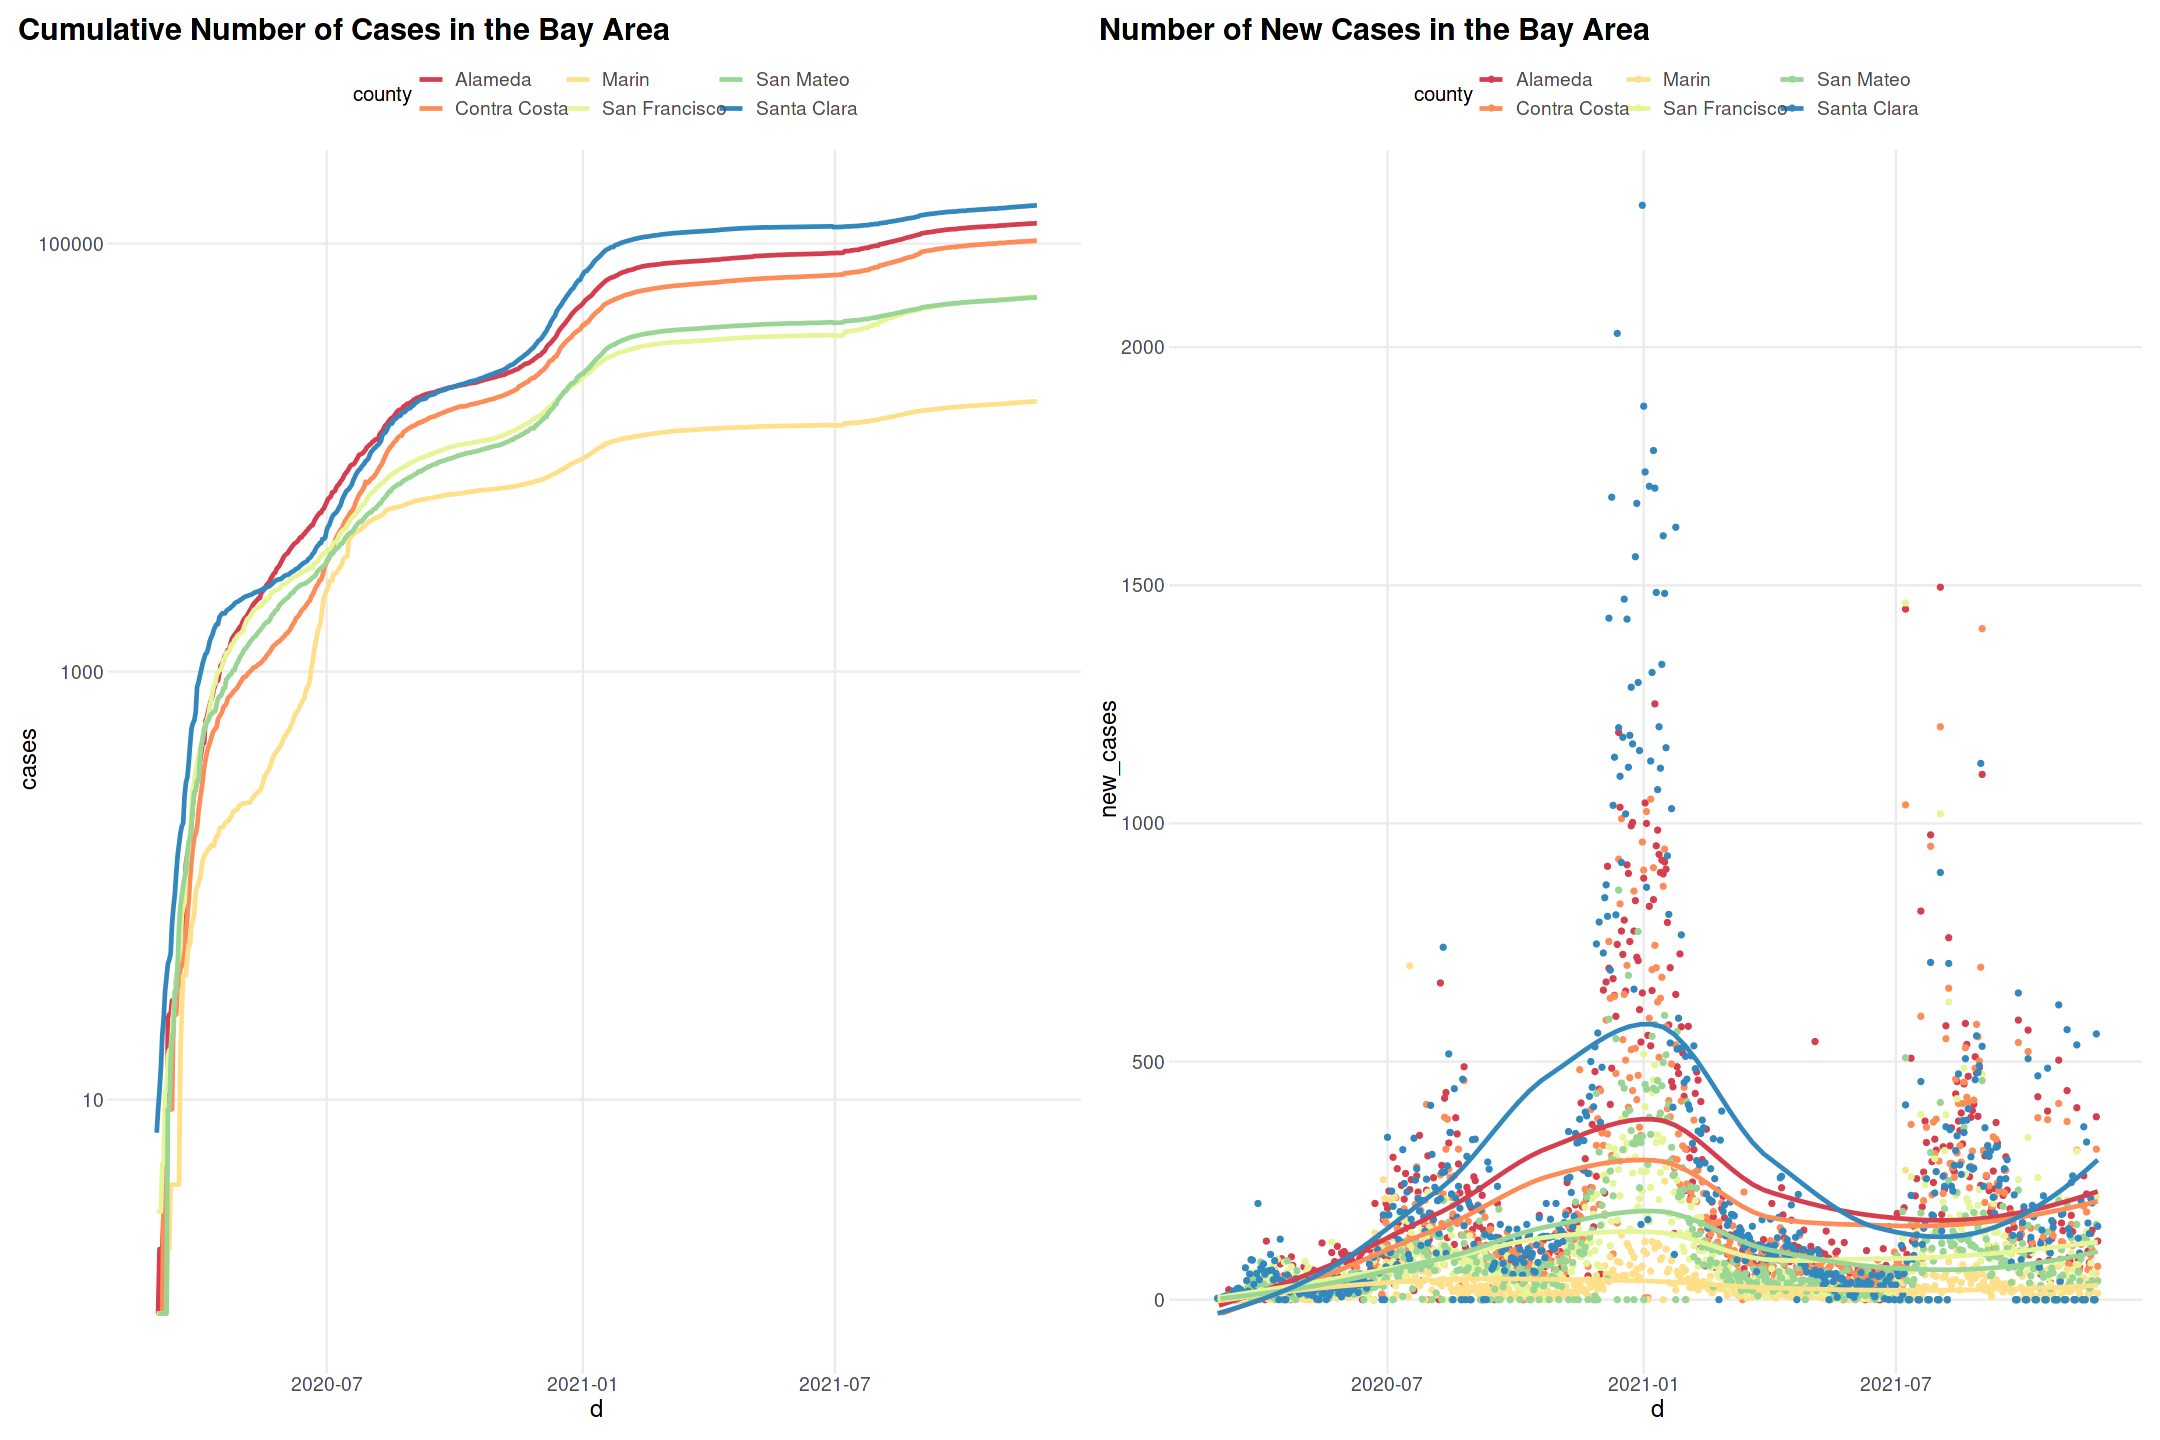

In [20]:
p1 = ggplot(bayrea_mar, aes(x = d, y = cases, group = county, colour = county)) +
  geom_line(size = 1) +
  scale_y_log10() +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("Cumulative Number of Cases in the Bay Area")

p2 = ggplot(bayrea_mar, aes(x = d, y = new_cases, group = county, colour = county)) +
  geom_point(size = 1) +
    geom_smooth(se = F) +
    scale_colour_brewer(palette = 'Spectral') +
    ggtitle("Number of New Cases in the Bay Area")
options(repr.plot.width = 18, repr.plot.height=12)
(p1 | p2)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


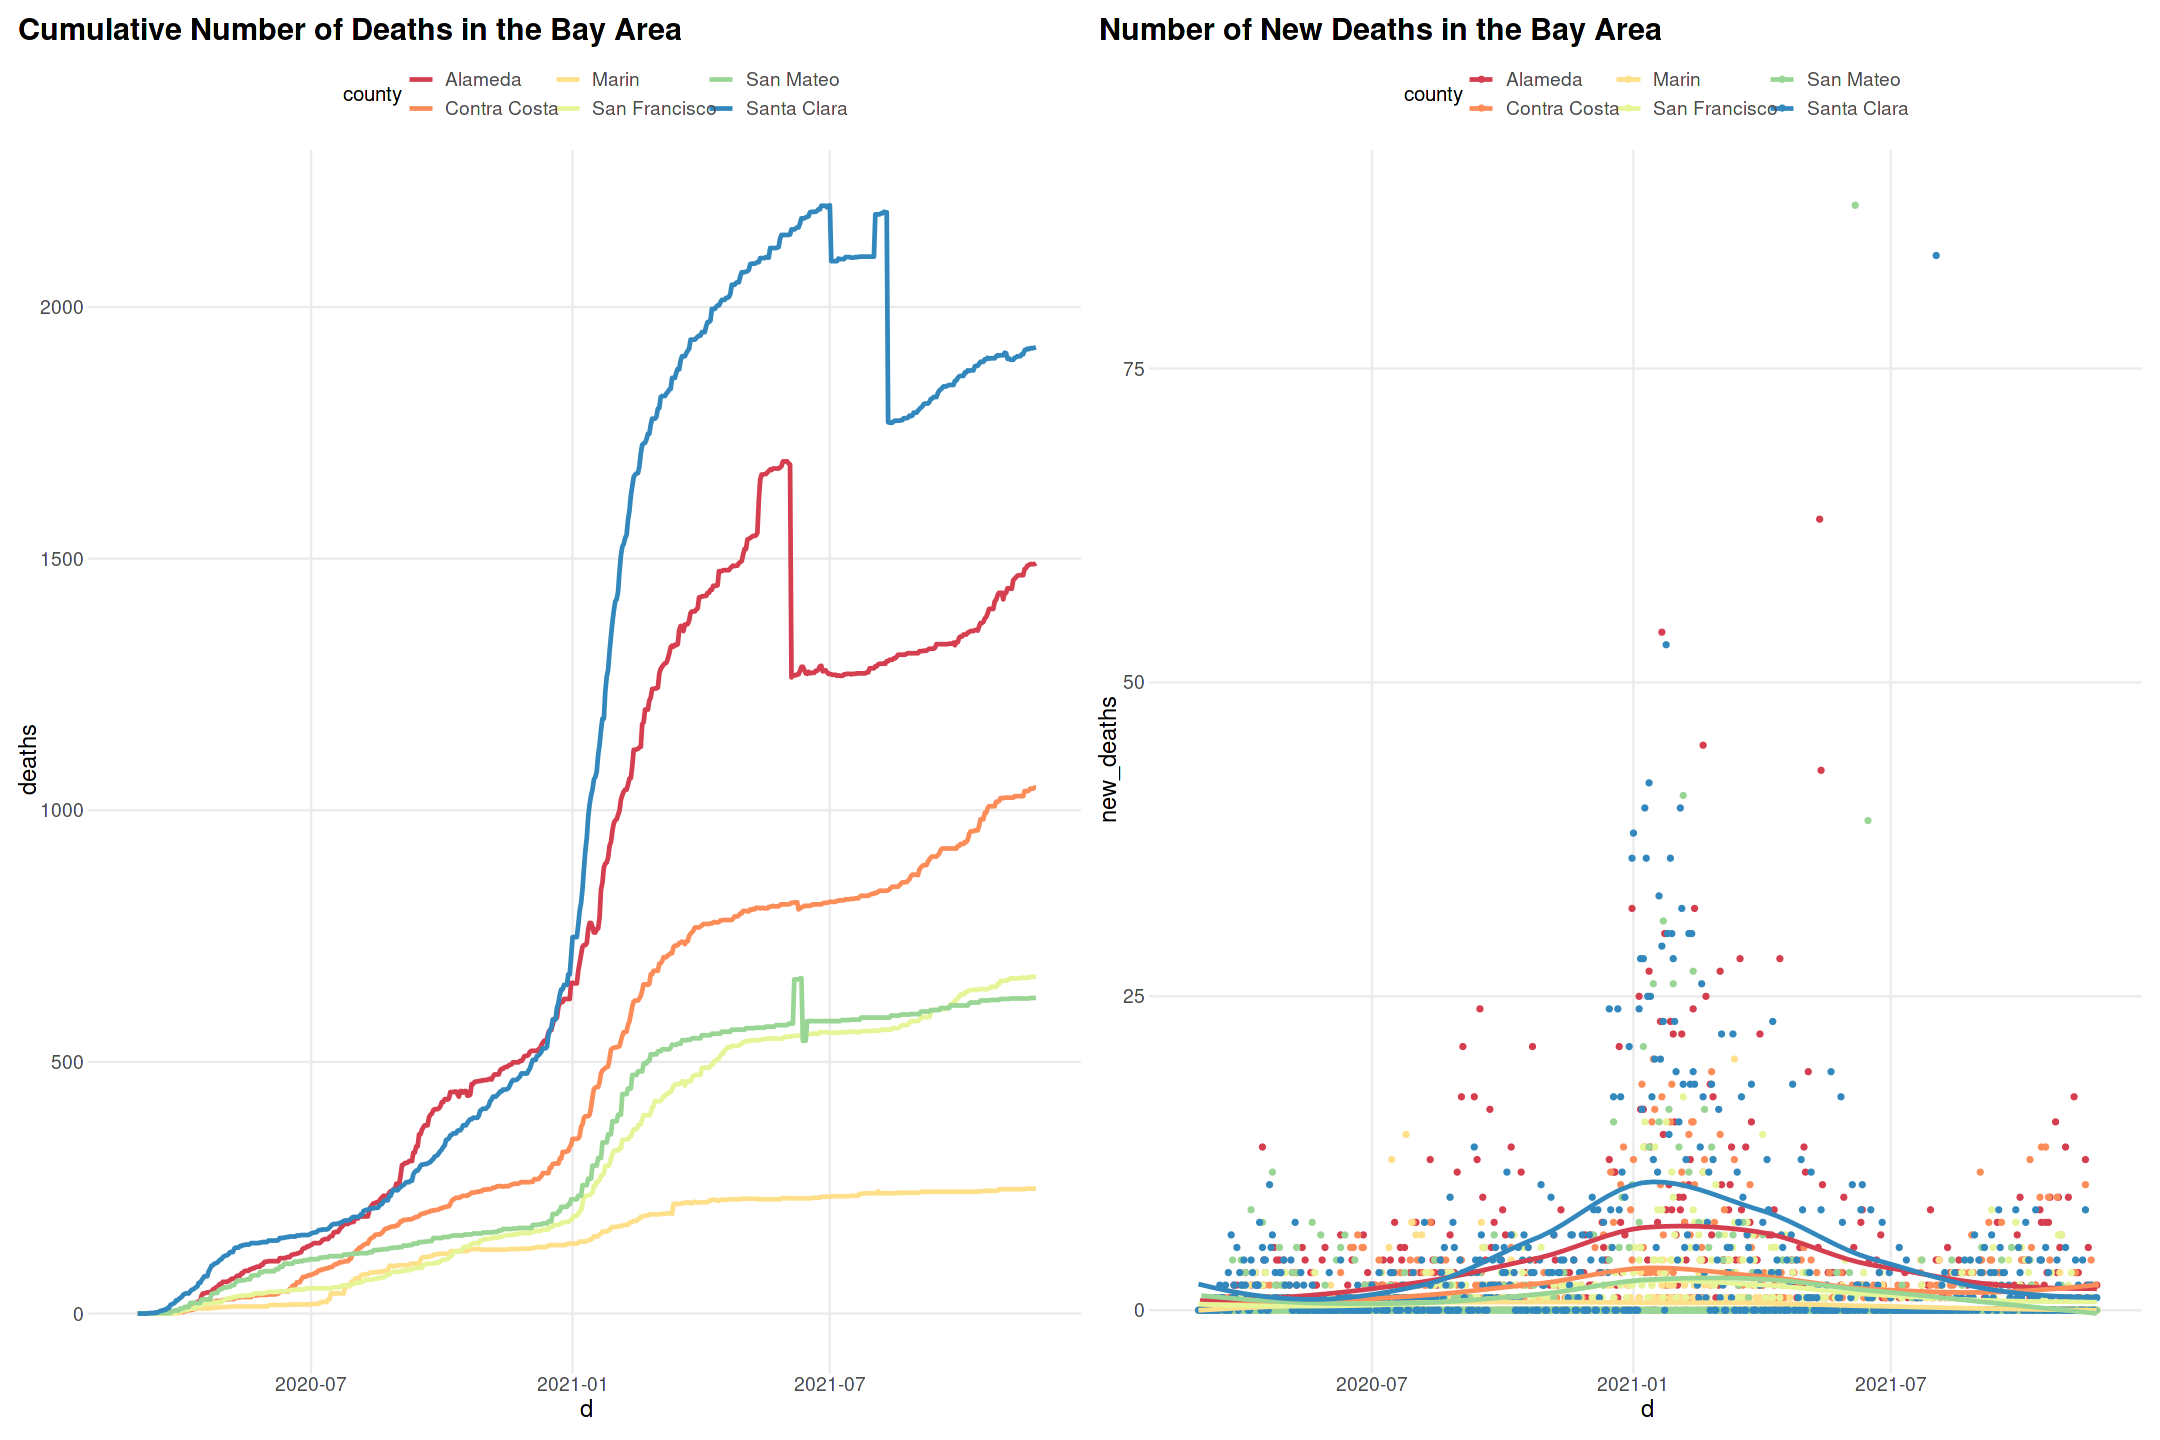

In [21]:
p1 = ggplot(bayrea_mar, aes(x = d, y = deaths, group = county, colour = county)) +
  geom_line(size = 1) +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("Cumulative Number of Deaths in the Bay Area")
p2 = ggplot(bayrea_mar, aes(x = d, y = new_deaths, group = county, colour = county)) +
  geom_point(aes(y = new_deaths), size = 1) +
#   geom_line(size = 1) +
  geom_smooth(se = F) +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("Number of New Deaths in the Bay Area")
(p1 | p2)